In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import datetime

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn

In [2]:
mv = pd.read_csv('e:/DS/data/ml/movies.csv',  sep=',')
tags = pd.read_csv('e:/DS/data/ml/tags.csv',  sep=',')
ln = pd.read_csv('e:/DS/data/ml/links.csv',  sep=',')
rt = pd.read_csv('e:/DS/data/ml/ratings.csv',  sep=',')


In [3]:
mv.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [5]:
ln.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
rt.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
mv.info(), rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


(None, None)

In [22]:
#сколько всего пользователей
rt['userId'].nunique()

610

In [23]:
#количество фильмов
rt['movieId'].nunique()

9724

In [24]:
rt['rating'].min(),rt['rating'].max()

(0.5, 5.0)

### 2.Распределения количества оценок по фильмам и по пользователям

Распределение пользователей(посчитаем сколько отзывов оставил каждый пользователь, сгруппируем и посмотрим распределение)

In [25]:
#сколько отзывов оставил каждый пользоватлей
users_count = rt.groupby(['userId'], as_index=False)['rating'].count().add_prefix('cnt_').sort_values('cnt_rating')

                                     

In [26]:
users_count.reset_index()
users_count.head(), users_count.tail() 
users_count['cnt_rating'].min(), users_count['cnt_rating'].max()


(20, 2698)

In [27]:
users_count2 = users_count.groupby(['cnt_rating'], as_index=False).count().sort_values('cnt_userId')
users_count2= users_count2.rename(index=str, columns={"cnt_rating": "cnt_by_user", "cnt_userId": "cnt_users"})

In [28]:
def devide_group(x):
    if x>0 and x<=20:
        y=20
    elif x>20 and x<=30:
        y=30
    elif  x>30 and x<=50:
        y=50
    elif  x>50 and x<=100:
        y=100  
    elif  x>100 and x<=200:
        y=200
    elif  x>200 and x<=300:
        y=300    
    elif  x>300 and x<=500:
        y=500    
    elif x >500:
        y=600       
    return y

In [29]:
users_count2['group'] = users_count2['cnt_by_user'].apply(lambda x:devide_group(x) )

In [30]:
users_count3 = users_count2.groupby(['group'], as_index=False)['cnt_users'].sum().sort_values('group')

In [31]:
users_count3.head(15)

,group,cnt_users
0,20,14
1,30,98
2,50,120
3,100,133
4,200,112
5,300,50
6,500,40
7,600,43


In [32]:

# Data for plotting
x = users_count3.group
y = users_count3.cnt_users

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='к-во рейтингов', ylabel='к-во пользователей',
       title='Распределение рейтингов')
ax.grid()

fig.savefig("test.png")
plt.show()

<Figure size 640x480 with 1 Axes>

Видим, что до 20 отзывов оставили всего 14 пользователей, после 200 резкое падение

##### Посмотрим распределение по фильмам

In [33]:
#сколько отзывов оставил каждый пользоватлей
movies_count = rt.groupby(['movieId'], as_index=False)['rating'].count().add_prefix('cnt_').sort_values('cnt_rating')
movies_count['cnt_rating'].min(), movies_count['cnt_rating'].max()
                                     

(1, 329)

In [34]:
movies_count2 = movies_count.groupby(['cnt_rating'], as_index=False).count().sort_values('cnt_movieId')
movies_count2= movies_count2.rename(index=str, columns={"cnt_rating": "cnt_rating", "cnt_movieId": "cnt_movies"})

In [35]:
def devide_group2(x):
    if x>0 and x<=20:
        y=20
    elif x>20 and x<=30:
        y=30
    elif  x>30 and x<=50:
        y=50
    elif  x>50 and x<=100:
        y=100  
    elif  x>100 and x<=150:
        y=150
    elif  x>150 and x<=200:
        y=200    
    elif  x>200 and x<=300:
        y=300    
    elif x >300:
        y=350       
    return y

In [36]:
movies_count2['group'] = movies_count2['cnt_rating'].apply(lambda x:devide_group2(x) )
movies_count3 = movies_count2.groupby(['group'], as_index=False)['cnt_movies'].sum().sort_values('group')

In [37]:
movies_count3

,group,cnt_movies
0,20,8489
1,30,375
2,50,424
3,100,302
4,150,91
5,200,25
6,300,15
7,350,3


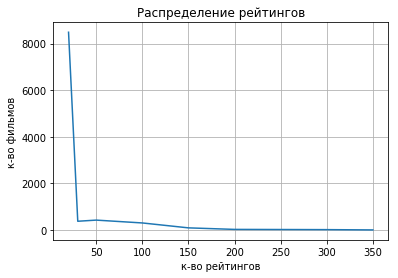

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
x = movies_count3.group
y = movies_count3.cnt_movies

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='к-во рейтингов', ylabel='к-во фильмов',
       title='Распределение рейтингов')
ax.grid()

fig.savefig("test.png")
plt.show()

Видим, что большее количество фильмов имеет меньше 20 отзывов, а больше 150 всего 43 фильма

### 3.Оценить средние оценки по фильмам и рейтингам

In [47]:
agg = {
    'rating':{
        'mean',
        ''
    }
}
avr = rt.groupby(['movieId'], as_index=False)['rating'].agg(['mean', 'count'])

avr.iloc[3]

mean     2.357143
count    7.000000
Name: 4, dtype: float64

In [48]:
rt[rt['movieId']==4]

,userId,movieId,rating,timestamp
562,6,4,3.0,845554349
1386,14,4,3.0,835441653
13075,84,4,3.0,858772461
23702,162,4,3.0,836684306
38179,262,4,1.0,840306203
62011,411,4,2.0,835533021
95103,600,4,1.5,1237760055


In [49]:
df = pd.merge(rt,avr, how = 'inner',left_on="movieId" , right_on="movieId" )

In [50]:
avr2 = rt.groupby(['userId'], as_index=False)['rating'].agg(['mean', 'std'])

In [51]:
df = pd.merge(df,avr2, how = 'inner',left_on="userId" , right_on="userId" )

In [52]:
df= df.rename(index=str, columns={"rating_x": "rating", "mean_x": "movie_mean", "mean_y": "user_mean"})

In [55]:
df.head(3)

,userId,movieId,rating,timestamp,movie_mean,count,user_mean,std
0,1,1,4.0,964982703,3.920930,215,4.366379,0.800048
1,1,3,4.0,964981247,3.259615,52,4.366379,0.800048
2,1,6,4.0,964982224,3.946078,102,4.366379,0.800048


### 4,5. Фильм нравится всем или никому

In [66]:
#нравятся всем, так как большинство фильмов имеет не больше 20 рейтингов
best = df[(df['movie_mean']>=4.2)  &  (df['count']>=30)]['movieId'].unique() #sort_values('mean',ascending=False)
best

array([   50,   260,   527,  1089,  1196,  1197,  1198,  1208,  1213,
        2329,  2959,   318, 48516,   750, 58559,   858,   904,  1193,
        1252,  1221,  1276,  3275,  1267,   912,  1204,  1233],
      dtype=int64)

In [67]:
mv[mv.movieId.isin(best)]

,movieId,title,genres
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
461,527,Schindler's List (1993),Drama|War
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
659,858,"Godfather, The (1972)",Crime|Drama
686,904,Rear Window (1954),Mystery|Thriller
694,912,Casablanca (1942),Drama|Romance
828,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller
896,1193,One Flew Over the Cuckoo's Nest (1975),Drama


In [50]:
#не нравятся никому
worst =  df[(df['mean']<=2.0)  &  (df['count']>=15)]['movieId'].unique() #sort_values('mean',ascending=False)

In [51]:
mv[mv.movieId.isin(worst)]

,movieId,title,genres
478,546,Super Mario Bros. (1993),Action|Adventure|Children|Comedy|Fantasy|Sci-Fi
1145,1499,Anaconda (1997),Action|Adventure|Thriller
1173,1556,Speed 2: Cruise Control (1997),Action|Romance|Thriller
1373,1882,Godzilla (1998),Action|Sci-Fi|Thriller
1812,2412,Rocky V (1990),Action|Drama
1989,2643,Superman IV: The Quest for Peace (1987),Action|Adventure|Sci-Fi
2683,3593,Battlefield Earth (2000),Action|Sci-Fi



### 6. Смещение оценок пользователей

Для определения смещения оценок посмотри распределения оценок

In [3]:
users_mean_rating = rt.groupby(by=['userId'])['rating'].mean().reset_index()
users_mean_rating.columns = ['userId', 'rating']
users_mean_rating.head()

,userId,rating
0,1,4.366379
1,2,3.948276
2,3,2.435897
3,4,3.555556
4,5,3.636364


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


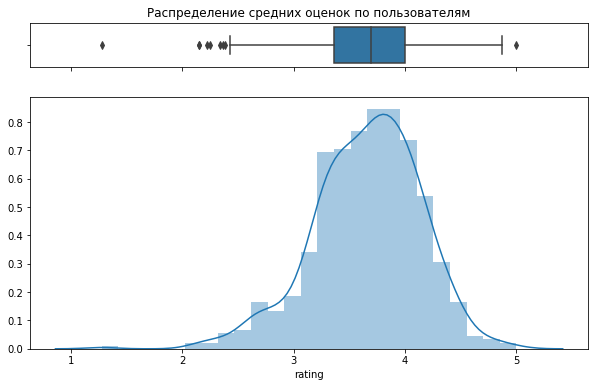

In [9]:
fig, (ax_boxplot, ax_hist) = plt.subplots(2,sharex=True, figsize =(10,6),gridspec_kw={"height_ratios":(.15,.85)} )
sbn.boxplot(users_mean_rating['rating'], ax=ax_boxplot )
sbn.distplot(users_mean_rating['rating'], ax=ax_hist )

ax_boxplot.set(xlabel = '');
ax_boxplot.set_title('Распределение средних оценок по пользователям');

Распределение похоже на нормальное, значит в  коридоре двух std у нас будет 95% всех наблюдений,одно 68%. 
Поэтому можно определить сильные отклонения через mean +- 2*std

In [19]:
#посмотрим среднее распределения оценок пользователей
mean = users_mean_rating['rating'].mean()
std = users_mean_rating['rating'].std()
min_norm = mean - std
max_norm = mean + std
mean, std,min_norm, max_norm


(3.657222337747402, 0.4806353173349684, 3.1765870204124336, 4.13785765508237)

In [20]:

print('Количество  занижающих:', len(users_mean_rating[users_mean_rating.rating < min_norm]))
print('Количество  завыщающих:', len(users_mean_rating[users_mean_rating.rating > max_norm]))

Количество  занижающих: 81
Количество  завыщающих: 87


In [21]:
min_norm = mean - 2*std
max_norm = mean + 2*std
mean, std,min_norm, max_norm

(3.657222337747402, 0.4806353173349684, 2.695951703077465, 4.6184929724173385)

In [22]:
print('Количество сильно занижающих:', len(users_mean_rating[users_mean_rating.rating < min_norm]))
print('Количество сильно завыщающих:', len(users_mean_rating[users_mean_rating.rating > max_norm]))

Количество сильно занижающих: 24
Количество сильно завыщающих: 8


In [119]:
#первый вариант
#отличение оценки пользователя от средней оценки фильма
df['user_std'] = df['rating'] - df['movie_mean']
df2 = df.groupby(['userId'], as_index=False)['user_std'].agg(['sum', 'count', 'mean'])


In [120]:
df2[df2['mean']<-0.5]

,sum,count,mean
userId,,,
3,-44.816478,39,-1.149140
19,-366.369841,703,-0.521152
22,-139.244466,119,-1.170122
28,-317.106756,570,-0.556328
36,-47.525130,60,-0.792086
47,-74.280352,140,-0.530574
50,-215.355418,310,-0.694695
54,-20.992310,33,-0.636131
55,-19.403871,25,-0.776155


In [121]:
#второй вариант
df['user_std2'] = (df['rating'] - df['user_mean'])/df['std']
df3 = df.groupby(['userId'], as_index=False)['user_std2'].agg(['sum', 'count', 'mean'])

In [124]:
df3[df3['mean']<0]

,sum,count,mean
userId,,,
12,-3.330669e-16,32,-1.040834e-17
14,-5.329071e-15,48,-1.110223e-16
15,-5.967449e-16,135,-4.420332e-18
16,-3.108624e-15,98,-3.172066e-17
17,-1.476597e-14,105,-1.406282e-16
18,-2.975398e-14,502,-5.927087e-17
20,-3.705369e-15,242,-1.531144e-17
21,-2.211564e-13,443,-4.992244e-16
26,-1.332268e-15,21,-6.344132e-17


In [96]:
df2[df2['mean']<0]

,sum,count,mean
userId,,,
12,-3.330669e-16,32,-1.040834e-17
14,-5.329071e-15,48,-1.110223e-16
15,-5.967449e-16,135,-4.420332e-18
16,-3.108624e-15,98,-3.172066e-17
17,-1.476597e-14,105,-1.406282e-16
18,-2.975398e-14,502,-5.927087e-17
20,-3.705369e-15,242,-1.531144e-17
21,-2.211564e-13,443,-4.992244e-16
26,-1.332268e-15,21,-6.344132e-17


In [93]:
df2

,sum,count,mean
userId,,,
1,3.885781e-14,232,1.674905e-16
2,7.993606e-15,29,2.756416e-16
3,7.771561e-16,39,1.992708e-17
4,2.065015e-14,216,9.560254e-17
5,1.554312e-15,44,3.532528e-17
6,2.462475e-13,314,7.842276e-16
7,2.101097e-14,152,1.382301e-16
8,1.088019e-14,47,2.314933e-16
9,6.883383e-15,46,1.496388e-16


### 7.Постоим рекомендательную систему

In [15]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import train_test_split
from surprise import accuracy
import numpy as np

In [16]:
reader = Reader(rating_scale=(0.5, 5))  
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']],reader)

NameError: name 'df' is not defined

In [56]:
data

In [57]:
param_grid = {
    'lr_all': [0.005, 0.05],
    'reg_all': [0.02, 0.002],
    'n_factors': [5, 10, 100, 500],
    'n_epochs': [10, 100]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

0.8691405988430893


In [370]:
print(gs.best_score)

{'rmse': 0.8703370945631276, 'mae': 0.6665635539094863}


In [178]:
gs.best_params

{'rmse': {'lr_all': 0.05, 'reg_all': 0.02, 'n_factors': 500, 'n_epochs': 100},
 'mae': {'lr_all': 0.05, 'reg_all': 0.02, 'n_factors': 500, 'n_epochs': 100}}

In [ ]:
svd = SVD(**gs.best_params['rmse'])

In [372]:
trainset, testset = train_test_split(data, test_size=.25)

In [373]:
svd.fit(trainset)


In [374]:
predictions = svd.test(testset)

In [ ]:
predictions

In [376]:
svd.predict(59, 1151)

Prediction(uid=59, iid=1151, r_ui=None, est=4.967434280236602, details={'was_impossible': False})

In [379]:
accuracy.rmse(predictions)

RMSE: 0.8632


0.8632217741663452

### 8.Получить рекомендации 

Рекомендации для существующего пользователя

In [68]:
iids = df['movieId'].unique()

In [69]:
iidsUser = df.loc[df['userId']==384, 'movieId']
iids_to_pred =  np.setdiff1d(iids,iidsUser) 

In [70]:
len(iids), len(iids_to_pred), len(iidsUser)

(9724, 9654, 70)

In [72]:
testset  = [[384, iid, 4.] for iid in iids_to_pred]
predictions = svd.test(testset)
predictions[2]

Prediction(uid=617, iid=3, r_ui=4.0, est=3.275378141706254, details={'was_impossible': False})

In [73]:
pred_ratings = np.array([pred.est for pred in predictions ])
i_max = pred_ratings.argmax()
iid = iids_to_pred[i_max]
print("Лучший фильм для этого пользователя {0} c предсказанным рейтингом  {1}".format(mv[mv.movieId==iid], pred_ratings[i_max]))

Лучший фильм для этого пользователя       movieId                                             title       genres
9618   177593  Three Billboards Outside Ebbing, Missouri (2017)  Crime|Drama c предсказанным рейтингом  4.308151593246583


Рекомендации для нового пользователя

In [400]:
testset  = [[615, iid, 4.] for iid in iids]
predictions = svd.test(testset)
predictions[0]

Prediction(uid=615, iid=1, r_ui=4.0, est=3.833357664235556, details={'was_impossible': False})

In [401]:
pred_ratings = np.array([pred.est for pred in predictions ])
i_max = pred_ratings.argmax()
iid = iids[i_max]
print("Лучший фильм для этого пользователя {0} c предсказанным рейтингом  {1}".format(iid, pred_ratings[i_max]))

Лучший фильм для этого пользователя 177593 c предсказанным рейтингом  4.353718920989347


In [53]:
mv[mv.movieId==177593]

,movieId,title,genres
9618,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama


In [404]:
# Этот фильм  входит в лучшие 
df[df['movieId']==177593]

,userId,movieId,rating,timestamp,mean,count,user_mean
1166,18,177593,4.5,1534007386,4.75,8,3.732072
19866,233,177593,5.0,1524781384,4.75,8,3.300000
35789,414,177593,4.5,1521844144,4.75,8,3.391957
72524,318,177593,4.5,1516826106,4.75,8,3.755973
85565,338,177593,5.0,1530148460,4.75,8,2.935897
92527,25,177593,5.0,1535470532,4.75,8,4.807692
94044,212,177593,5.0,1527794935,4.75,8,3.590726
97115,209,177593,4.5,1524522248,4.75,8,4.242857


### 9,10 Добавим нового пользователя 617  и его рейтинги, дадим ему рекомендации

In [ ]:
def showUserRec(df,userId,k):
    iids = df['movieId'].unique()
    iidsUser = df.loc[df['userId']==userId, 'movieId']
    iids_to_pred =  np.setdiff1d(iids,iidsUser) 
    testset  = [[userId, iid, 4.] for iid in iids_to_pred]
    predictions = svd.test(testset)
    pred_ratings = np.array([pred.est for pred in predictions ])
    idx = (-pred_ratings).argsort()[:k]
    
    return mv[mv.movieId.isin(iids_to_pred[idx])]


In [181]:
#добавим рейтинги
my_rt = pd.read_csv('e:/DS/data/ml/my_ratings.csv',  sep=';')

In [182]:
#добавим рейтинги к основным данным
df_list = [rt, my_rt]
common_cols = list(set.intersection(*(set(c) for c in df_list)))
df_new = pd.concat([df[common_cols] for df in df_list], ignore_index=True)

In [188]:
df_new[df_new.userId ==617].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 100836 to 100873
Data columns (total 4 columns):
userId       38 non-null int64
movieId      38 non-null int64
rating       38 non-null float64
timestamp    0 non-null float64
dtypes: float64(2), int64(2)
memory usage: 1.5 KB


In [185]:
#перестроим модель с новыми данными
reader = Reader(rating_scale=(0.5, 5))  
data = Dataset.load_from_df(df_new[['userId', 'movieId', 'rating']],reader)

In [186]:
svd = SVD(**gs.best_params['rmse'])
trainset, testset = train_test_split(data, test_size=.25)
svd.fit(trainset)

In [187]:
showUserRec(df_new,617,6)

,movieId,title,genres
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
820,1080,Monty Python's Life of Brian (1979),Comedy
878,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
969,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
1486,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller


Очень хороший подбор, эти фильмы не были отмечены, а мой рейтинг для них высокий

In [149]:
#не подходящие для данного пользователя
idx = (pred_ratings).argsort()[:5]
mv[mv.movieId.isin(iids_to_pred[idx])]

,movieId,title,genres
637,810,Kazaam (1996),Children|Comedy|Fantasy
2460,3273,Scream 3 (2000),Comedy|Horror|Mystery|Thriller
2683,3593,Battlefield Earth (2000),Action|Sci-Fi
3804,5323,Jason X (2002),Horror|Sci-Fi|Thriller
6141,43919,Date Movie (2006),Comedy|Romance


### 11 Построим модель по жанру, который чаще встречается у пользователя, посмотрим рекомендации.

In [165]:
searchTerm = 'Adventure'
genres=mv[[searchTerm in x for x in mv['genres']]]['movieId']

In [167]:
df_new = df_new[df_new.movieId.isin(genres)]

In [168]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24170 entries, 0 to 100854
Data columns (total 4 columns):
userId       24170 non-null int64
movieId      24170 non-null int64
rating       24170 non-null float64
timestamp    24161 non-null float64
dtypes: float64(2), int64(2)
memory usage: 944.1 KB


In [169]:
#перестроим модель с новыми данными
reader = Reader(rating_scale=(0.5, 5))  
data = Dataset.load_from_df(df_new[['userId', 'movieId', 'rating']],reader)

In [170]:
svd = SVD(**gs.best_params['rmse'])
trainset, testset = train_test_split(data, test_size=.25)
svd.fit(trainset)

In [172]:
showUserRec(df_new,617,6)

,movieId,title,genres
903,1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western
916,1215,Army of Darkness (1993),Action|Adventure|Comedy|Fantasy|Horror
4795,7143,"Last Samurai, The (2003)",Action|Adventure|Drama|War
5236,8580,Into the Woods (1991),Adventure|Comedy|Fantasy|Musical
8274,105504,Captain Phillips (2013),Adventure|Drama|Thriller|IMAX
8475,112852,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi


In [ ]:
По жанру тоже подходящие фильмы, но хуже чем по полной выборке. У них рейтинг по imdb чуть ниже. Я думаю, потому что 
каждый фильм описывается несколькими жанрами, а не относится только к одному, поэтому выбор Adventure служит ограничевающим
фактором.
